In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install geemap
!pip install geopandas
!pip install rasterio
!pip install rasterio geopandas scikit-learn matplotlib seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 49.7 MB/s eta 0:00:00


# Step 1: Upload the multiband GeoTIFF image and training data GeoPackage to Google Colab (or mount your Google Drive folder)

In [3]:
import geopandas as gpd
import ee
import geemap
import os
# Import necessary libraries
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Step 2: Read the multiband tiff image

In [4]:
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.features import geometry_mask
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load images
def load_image(image_path):
    with rasterio.open(image_path) as src:
        img = src.read()
        transform = src.transform
        crs = src.crs
    return img, transform, crs

img_2017, transform_2017, crs_2017 = load_image('/content/drive/My Drive/EarthEngine/Sentinel2_2017.tif')
img_2024, transform_2024, crs_2024 = load_image('/content/drive/My Drive/EarthEngine/Sentinel2_2024.tif')

# Load labeled data
# Path to the labeled shapefile
geopackage_path = '/content/drive/MyDrive/EO/ROI/ROI.gpkg'

# Read the labeled GeoPackage file
labeled_gdf = gpd.read_file(geopackage_path)

# Ensure the GeoDataFrame is in the correct projection (WGS84)
labeled_gdf = labeled_gdf.to_crs(epsg=4326)

# Filter out rows with None or empty geometries
labeled_gdf = labeled_gdf[~labeled_gdf.is_empty]


# Step 3: Read the vector training areas from GeoPackage

In [5]:
def preprocess_geometries(labeled_gdf, target_crs):
    labeled_gdf = labeled_gdf[labeled_gdf['geometry'].notnull()]
    labeled_gdf = labeled_gdf[labeled_gdf.is_valid]
    if labeled_gdf.crs != target_crs:
        labeled_gdf = labeled_gdf.to_crs(target_crs)
    return labeled_gdf

def extract_patches(image, labeled_gdf, patch_size=5):
    half_size = patch_size // 2
    X = []
    y = []
    for index, row in labeled_gdf.iterrows():
        geom = [row['geometry']]
        label = row['id'] - 1  # Adjust labels to be zero-indexed

        mask = geometry_mask(geom, transform=transform_2017, invert=True, out_shape=(image.shape[1], image.shape[2]))

        rows, cols = np.where(mask)
        for r, c in zip(rows, cols):
            if (r - half_size < 0) or (r + half_size >= image.shape[1]) or (c - half_size < 0) or (c + half_size >= image.shape[2]):
                continue
            patch = image[:, r - half_size:r + half_size + 1, c - half_size:c + half_size + 1]
            X.append(patch)
            y.append(label)

    return np.array(X), np.array(y)

# Preprocess geometries
target_crs = crs_2017
labeled_gdf = preprocess_geometries(labeled_gdf, target_crs)

# Extract patches from the 2017 image
patch_size = 5
X_train, y_train = extract_patches(img_2017, labeled_gdf, patch_size=patch_size)
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")

Training data shape: (30998, 10, 5, 5)
Training labels shape: (30998,)


In [55]:
X_train.shape

(2276, 2346, 10)

# Step 4: Extract pixel values from the image (X) corresponding to training data (y)

In [16]:
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (7, 7), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

patch_size = 5  # You can try slightly larger patch sizes if needed
input_shape = (patch_size, patch_size, img_2017.shape[0])  # (patch_height, patch_width, num_bands)
num_classes = len(np.unique(y_train))
model = create_cnn_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Reshape X_train to match the input shape of the CNN
X_train = X_train.transpose((0, 2, 3, 1))  # Transpose to (num_samples, patch_height, patch_width, num_bands)

# Split into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Train the model
history = model.fit(X_train_split, y_train_split, epochs=20, validation_data=(X_val_split, y_val_split), batch_size=32)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 5, 5, 32)          15712     
                                                                 
 conv2d_28 (Conv2D)          (None, 5, 5, 64)          18496     
                                                                 
 conv2d_29 (Conv2D)          (None, 5, 5, 128)         73856     
                                                                 
 flatten_9 (Flatten)         (None, 3200)              0         
                                                                 
 dense_18 (Dense)            (None, 128)               409728    
                                                                 
 dense_19 (Dense)            (None, 5)                 645       
                                                                 
Total params: 518437 (1.98 MB)
Trainable params: 51843

# Step 5: Split data into training and testing sets

# Step 6: Train a MLP classifier

291/291 - 2s - loss: 0.0987 - accuracy: 0.9601 - 2s/epoch - 6ms/step
Validation accuracy: 0.9601075053215027
291/291 [==============================] - 2s 5ms/step
Validation accuracy: 0.9601075268817204


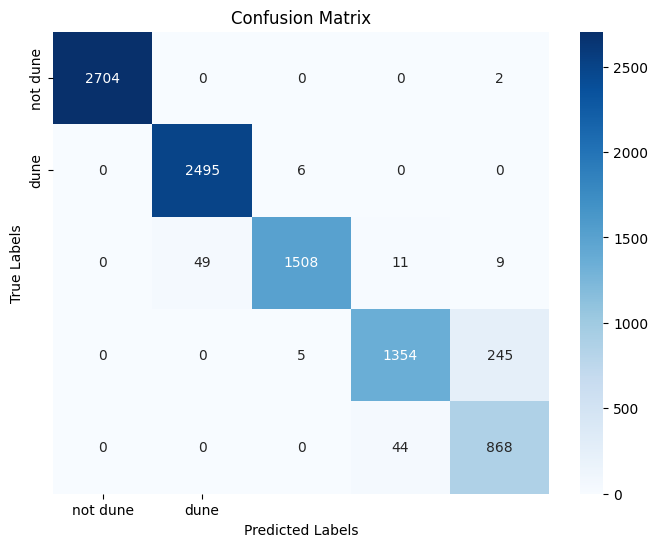

In [10]:

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val_split, y_val_split, verbose=2)
print(f'Validation accuracy: {val_acc}')

from sklearn.metrics import accuracy_score

# Predict the validation data
y_pred_val = model.predict(X_val_split)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Calculate validation accuracy
val_acc = accuracy_score(y_val_split, y_pred_val_classes)
print(f'Validation accuracy: {val_acc}')


# Compute confusion matrix
conf_matrix = confusion_matrix(y_val_split, y_pred_val_classes)
custom_labels = ['not dune', 'dune'] # {1:'not_dune', 2:'dune'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=custom_labels,
            yticklabels=custom_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




In [1]:
def classify_image(model, image, patch_size=500):
    half_size = patch_size // 2
    height, width = image.shape[1], image.shape[2]
    y_pred_full = np.zeros((height, width), dtype=np.int32)

    for r in range(half_size, height - half_size):
        for c in range(half_size, width - half_size):
            patch = image[:, r - half_size:r + half_size + 1, c - half_size:c + half_size + 1]
            patch = patch.transpose((1, 2, 0))  # Transpose to (patch_height, patch_width, num_bands)
            patch = patch[np.newaxis, ...]  # Add batch dimension
            y_pred_patch = model.predict(patch)
            y_pred_class = np.argmax(y_pred_patch, axis=1)
            y_pred_full[r, c] = y_pred_class

    return y_pred_full

# Classify the 2024 image
y_pred_2024 = classify_image(model, img_2024, patch_size=500)


NameError: name 'model' is not defined

# Step 7: Evaluate the classifier

In [ ]:
# Reshape the 2017 image data to (n_samples, n_features)
n_samples = img_2017.shape[1] * img_2017.shape[2]
X_2017 = img_2017.reshape((img_2017.shape[0], n_samples)).T

# Predict the land cover and land use for 2017
y_pred_2017 = mlp.predict(X_2017)

# Reshape the predictions back to the original image shape
y_pred_2017_img = y_pred_2017.reshape((img_2017.shape[1], img_2017.shape[2]))

# Save the classification result as a new GeoTIFF
#with rasterio.open('/content/drive/My Drive/EarthEngine/RF_2024_LCLU.tif', 'w', driver='GTiff',
#                   height=img_2017.shape[1], width=img_2017.shape[2], count=1, dtype=y_pred_2017_img.dtype,
#                   crs=src_2024.crs, transform=src_2024.transform) as dst:
#    dst.write(y_pred_2017_img, 1)

In [ ]:
# Reshape the 2024 image data to (n_samples, n_features)
n_samples = img_2024.shape[1] * img_2024.shape[2]
X_2024 = img_2024.reshape((img_2024.shape[0], n_samples)).T
#X_2024 = np.nan_to_num(X_2024, nan=0.0)

# Predict the land cover and land use for 2024
y_pred_2024 = mlp.predict(X_2024)

# Reshape the predictions back to the original image shape
y_pred_2024_img = y_pred_2024.reshape((img_2024.shape[1], img_2024.shape[2]))

# Save the classification result as a new GeoTIFF
#with rasterio.open('/content/drive/My Drive/EarthEngine/RF_2024_LCLU.tif', 'w', driver='GTiff',
#                   height=img_2024.shape[1], width=img_2024.shape[2], count=1, dtype=y_pred_2024_img.dtype,
#                   crs=src_2024.crs, transform=src_2024.transform) as dst:
#    dst.write(y_pred_2024_img, 1)


In [ ]:
import matplotlib.pyplot as plt

# Visualize the classification result for 2017
plt.figure(figsize=(10, 10))
plt.title("Land Cover and Land Use Classification for 2017")
plt.imshow(y_pred_2017_img, cmap='tab10')
plt.colorbar()
plt.show()

# Visualize the classification result for 2024
plt.figure(figsize=(10, 10))
plt.title("Land Cover and Land Use Classification for 2024")
plt.imshow(y_pred_2024_img, cmap='tab10')
plt.colorbar()
plt.show()